**GRAPH NEURAL NETWORKS FOR NEXT POINT OF
INTEREST RECOMMENDATION**

---
---


*Gavriel Di Nepi 2067753 - Jacopo Fabi 1809860 - Adriano Izzi 2048338*

In [1]:
from IPython.display import clear_output

In [2]:
!pip install torch_geometric
!pip install pytorch_lightning
clear_output()

In [3]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.nn import Linear
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence

# Import PyTorch Geometric
from torch_geometric.loader import DataLoader as GraphDataLoader
from torch_geometric.data import Data, InMemoryDataset, Batch
from torch_geometric.nn import GCNConv

# Import PyTorch Lightning e TorchMetrics
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import pytorch_lightning as pl
import torchmetrics
from torchmetrics import Metric, MetricCollection

import numpy as np
import pandas as pd
import random




In [4]:
if torch.cuda.is_available():
    print("CUDA is available! You can use GPU for training.")
    device = torch.device("cuda")
else:
    print("CUDA is not available. Training will be on CPU.")
    device = torch.device("cpu")

torch.set_default_device(device)

CUDA is available! You can use GPU for training.


# Data Acquisition
The dataset is loaded from a GitHub repository and read into a pandas dataframe

In [5]:
! git clone https://github.com/jfabi88/NYDataset.git

Cloning into 'NYDataset'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 3 (delta 0), reused 3 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (3/3), 16.21 MiB | 16.16 MiB/s, done.


In [6]:
df = pd.read_excel("/content/NYDataset/dataset_TSMC2014_NYC.xlsx", header=None)

In [7]:
df.columns = ["UserID", 'VenueID', 'VenueCategoryID', 'VenueCategoryName', 'Latitude', 'Longitude', 'TimezoneOffsetInMinutes', "UTCTime"]

In [8]:
df

,UserID,VenueID,VenueCategoryID,VenueCategoryName,Latitude,Longitude,TimezoneOffsetInMinutes,UTCTime
0,470,49bbd6c0f964a520f4531fe3,4bf58dd8d48988d127951735,Arts & Crafts Store,40.719810,-74.002581,-240,Tue Apr 03 18:00:09 +0000 2012
1,979,4a43c0aef964a520c6a61fe3,4bf58dd8d48988d1df941735,Bridge,40.606800,-74.044170,-240,Tue Apr 03 18:00:25 +0000 2012
2,69,4c5cc7b485a1e21e00d35711,4bf58dd8d48988d103941735,Home (private),40.716162,-73.883070,-240,Tue Apr 03 18:02:24 +0000 2012
3,395,4bc7086715a7ef3bef9878da,4bf58dd8d48988d104941735,Medical Center,40.745164,-73.982519,-240,Tue Apr 03 18:02:41 +0000 2012
4,87,4cf2c5321d18a143951b5cec,4bf58dd8d48988d1cb941735,Food Truck,40.740104,-73.989658,-240,Tue Apr 03 18:03:00 +0000 2012
...,...,...,...,...,...,...,...,...
227423,688,3fd66200f964a52000e71ee3,4bf58dd8d48988d1e7931735,Music Venue,40.733596,-74.003139,-300,Sat Feb 16 02:29:11 +0000 2013
227424,560,4bca32ff0687ef3be789dbcc,4bf58dd8d48988d16c941735,Burger Joint,40.745719,-73.993720,-300,Sat Feb 16 02:31:35 +0000 2013
227425,945,50a77716e4b0b5a9492f6f56,4bf58dd8d48988d103941735,Home (private),40.854364,-73.883070,-300,Sat Feb 16 02:33:16 +0000 2013
227426,671,4514efe0f964a520e7391fe3,4bf58dd8d48988d11d941735,Bar,40.735981,-74.029309,-300,Sat Feb 16 02:34:31 +0000 2013


# Data Analysis and Manipulation

## Data Cleaning
We clean and adjust the dataframe to prepare it for analysis. Specifically, we:

- Modify columns to create a more consistent and understandable structure.
- Transform data in specific columns to standardize formats or apply necessary calculations.
- Resolve discrepancies by checking for inconsistent values to ensure data accuracy

First, we will display the rows in the dataframe and determine the number of unique users, places, and categories

In [9]:
print(df.shape[0], "rows x", df.shape[1], "columns")
users = df.UserID.unique()
print("Users:       ", len(users))
venues = df.VenueID.unique()
print("Venues:      ", len(venues))
cateogories = df.VenueCategoryID.unique()
print("Categories:  ", len(cateogories))

227428 rows x 8 columns
Users:        1083
Venues:       38333
Categories:   400


We want to understand how the venues are distributed in the dataframe. Therefore, we group the venues into bins based on the number of their occurrences


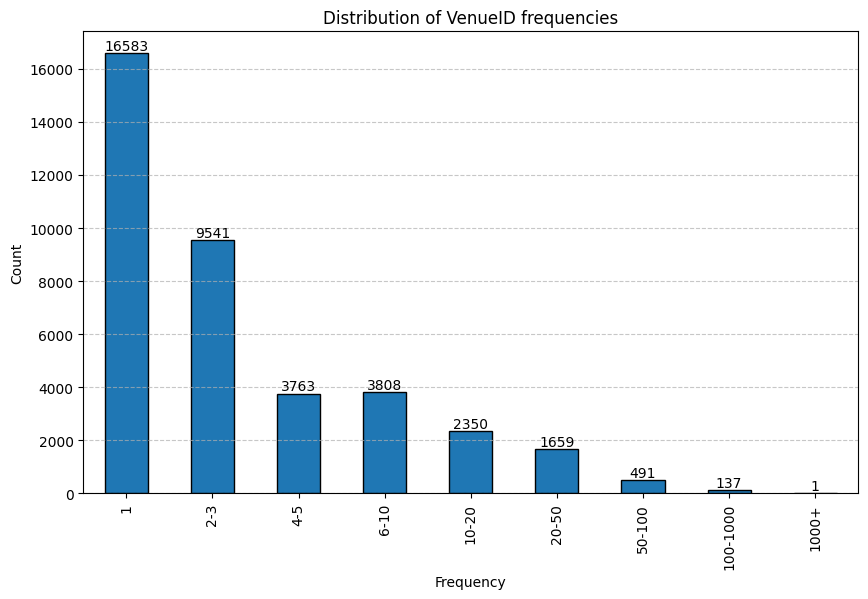

In [10]:
import matplotlib.pyplot as plt

venue_counts = df['VenueID'].value_counts()

bins = [1, 2, 4, 6, 11, 21, 51, 101, 1001, venue_counts.max() + 1]
labels = ['1', '2-3', '4-5', '6-10', '10-20',
          '20-50', '50-100', '100-1000', '1000+']

venue_counts_bin = pd.cut(venue_counts, bins=bins, labels=labels, right=False)
group_counts = venue_counts_bin.value_counts().sort_index()

plt.figure(figsize=(10, 6))
group_counts.plot(kind='bar', edgecolor='black')

for i, count in enumerate(group_counts):
    plt.text(i, count + 0.5, str(count), ha='center', va='bottom', fontsize=10)

plt.xlabel('Frequency')
plt.ylabel('Count')
plt.title('Distribution of VenueID frequencies')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

We observe that there are about 30,000 places that appear fewer than 10 times among all the check-ins. Therefore, we save the most frequent venueIDs, so the venueIDs that appear more than 9 times

In [11]:
venue_counts = df['VenueID'].value_counts()
frequent_venue_ids = venue_counts[venue_counts >= 10].index.to_numpy()
np.random.shuffle(frequent_venue_ids)

In [12]:
num_of_labels = len(frequent_venue_ids)
num_of_labels

5135

Now we apply a mapping to the dataframe: the most frequent venueIDs will have a ID between 0 and *len(frequent_venue_ids)*, in a random order

In [13]:
venue_mapping = {venue: idx for idx, venue in enumerate(frequent_venue_ids)}
offset = len(venue_mapping)

for venue_id in venue_counts.index:
    if venue_id not in venue_mapping:
        venue_mapping[venue_id] = offset
        offset += 1

df['VenueID'] = df['VenueID'].map(venue_mapping)

In [14]:
df

,UserID,VenueID,VenueCategoryID,VenueCategoryName,Latitude,Longitude,TimezoneOffsetInMinutes,UTCTime
0,470,2444,4bf58dd8d48988d127951735,Arts & Crafts Store,40.719810,-74.002581,-240,Tue Apr 03 18:00:09 +0000 2012
1,979,971,4bf58dd8d48988d1df941735,Bridge,40.606800,-74.044170,-240,Tue Apr 03 18:00:25 +0000 2012
2,69,1288,4bf58dd8d48988d103941735,Home (private),40.716162,-73.883070,-240,Tue Apr 03 18:02:24 +0000 2012
3,395,21738,4bf58dd8d48988d104941735,Medical Center,40.745164,-73.982519,-240,Tue Apr 03 18:02:41 +0000 2012
4,87,3907,4bf58dd8d48988d1cb941735,Food Truck,40.740104,-73.989658,-240,Tue Apr 03 18:03:00 +0000 2012
...,...,...,...,...,...,...,...,...
227423,688,1639,4bf58dd8d48988d1e7931735,Music Venue,40.733596,-74.003139,-300,Sat Feb 16 02:29:11 +0000 2013
227424,560,4637,4bf58dd8d48988d16c941735,Burger Joint,40.745719,-73.993720,-300,Sat Feb 16 02:31:35 +0000 2013
227425,945,1422,4bf58dd8d48988d103941735,Home (private),40.854364,-73.883070,-300,Sat Feb 16 02:33:16 +0000 2013
227426,671,835,4bf58dd8d48988d11d941735,Bar,40.735981,-74.029309,-300,Sat Feb 16 02:34:31 +0000 2013


Now we remove the 'VenueCategoryName' column, as it will not be used

In [15]:
df = df.drop(columns=['VenueCategoryName'])

The VenueCategoryIDs are mapped through a dictionary



In [16]:
unique_category = df['VenueCategoryID'].unique()
category_to_number = {venue_id: i for i, venue_id in enumerate(unique_category)}

df['VenueCategoryID'] = df['VenueCategoryID'].map(category_to_number)
df

,UserID,VenueID,VenueCategoryID,Latitude,Longitude,TimezoneOffsetInMinutes,UTCTime
0,470,2444,0,40.719810,-74.002581,-240,Tue Apr 03 18:00:09 +0000 2012
1,979,971,1,40.606800,-74.044170,-240,Tue Apr 03 18:00:25 +0000 2012
2,69,1288,2,40.716162,-73.883070,-240,Tue Apr 03 18:02:24 +0000 2012
3,395,21738,3,40.745164,-73.982519,-240,Tue Apr 03 18:02:41 +0000 2012
4,87,3907,4,40.740104,-73.989658,-240,Tue Apr 03 18:03:00 +0000 2012
...,...,...,...,...,...,...,...
227423,688,1639,315,40.733596,-74.003139,-300,Sat Feb 16 02:29:11 +0000 2013
227424,560,4637,28,40.745719,-73.993720,-300,Sat Feb 16 02:31:35 +0000 2013
227425,945,1422,2,40.854364,-73.883070,-300,Sat Feb 16 02:33:16 +0000 2013
227426,671,835,97,40.735981,-74.029309,-300,Sat Feb 16 02:34:31 +0000 2013


If we look at the data, we can see that the same venueID does not always correspond to the same values of categoryID, latitude, and longitude. However, we want a consistent mapping. Therefore, we will take the most frequently occurring value among the data for each venue

In [17]:
df['Latitude'] = df.groupby('VenueID')['Latitude'].transform(lambda x: x.mode()[0])
df['Longitude'] = df.groupby('VenueID')['Longitude'].transform(lambda x: x.mode()[0])
df['VenueCategoryID'] = df.groupby('VenueID')['VenueCategoryID'].transform(lambda x: x.mode()[0])

Now we modify our dataframe converting the date to local time, and then removing the 'Timezone' and 'UTCTime' columns, as we will no longer use them

In [18]:
import pytz

df['UTCTime'] = pd.to_datetime(df['UTCTime'], format="%a %b %d %H:%M:%S %z %Y", utc=True)
df['Timestamp'] = df['UTCTime'].apply(lambda x: int(x.timestamp()))
df = df.drop(columns=['TimezoneOffsetInMinutes', 'UTCTime'])
df

,UserID,VenueID,VenueCategoryID,Latitude,Longitude,Timestamp
0,470,2444,0,40.719810,-74.002581,1333476009
1,979,971,1,40.606800,-74.044170,1333476025
2,69,1288,2,40.716162,-73.883070,1333476144
3,395,21738,3,40.744870,-73.982519,1333476161
4,87,3907,4,40.740104,-73.989658,1333476180
...,...,...,...,...,...,...
227423,688,1639,315,40.733596,-74.003139,1360981751
227424,560,4637,28,40.745719,-73.993720,1360981895
227425,945,1422,2,40.854364,-73.883070,1360981996
227426,671,835,97,40.735981,-74.029309,1360982071


Now we check if the dataframe is sorted by Timestamp, and if not, we sort it

In [19]:
is_sorted = df['Timestamp'].is_monotonic_increasing
if is_sorted:
    print("The 'UTCTime' column is sorted in ascending order.")
else:
    print("The 'UTCTime' column is NOT sorted in ascending order.")
    df = df.sort_values(by='Timestamp').reset_index(drop=True)
    is_sorted = df['Timestamp'].is_monotonic_increasing
    print("Now is sorted: ", is_sorted)

The 'UTCTime' column is NOT sorted in ascending order.
Now is sorted:  True


## Data Creation
We create two parameters that we will use in our model:
- **Grid**: The city of New York is divided into a grid based on latitude and longitude. The number of rectangles in the grid depends on a parameter **_alpha_**: the vertical size of each grid block is equal to ${MaxLongitudeDiff} \times {alpha}$ while the horizontal size is equal to ${MaxLatitudeDiff} \times {alpha}$
- **Hotness**: It is a value that determines how popular a place is. The hotness values were chosen based on the distribution of frequencies of the venues. The maximum value is 5

#### Grid

We find max/min values of latitude and longitude. Then we find the max distance between two places in our dataset

In [20]:
min_lat = df['Latitude'].min()
max_lat = df['Latitude'].max()
min_lon = df['Longitude'].min()
max_lon = df['Longitude'].max()
print("Min latitude: ", min_lat, "Max latitude:", max_lat)
print("Min longitude:", min_lon, "Max longitude: ", max_lon)

Min latitude:  40.55085246740427 Max latitude: 40.988331719265304
Min longitude: -74.27476644515991 Max longitude:  -73.68382519820906


In [21]:
diff_lat = (max_lat - min_lat)
diff_lon = (max_lon - min_lon)
print(diff_lat, diff_lon)

0.43747925186103487 0.5909412469508482


Alpha is a value that determine how many grid values do we want: a larger alpha corresponds to a greater number of elements in the grid

In [22]:
alpha = 40

We define a function that assing each place to a sector of a grid that represent the city of New York.
In this way we work we easy to manage values and also we group some elements togheter, making easier for the neural network to find similarities and to guess the next POI

In [23]:
n_lat_indices = int(diff_lat * alpha)
n_lon_indices = int(diff_lon * alpha)

def map_to_grid(lat, lon):
  lat = (lat - min_lat)
  lon = (lon - min_lon)
  lat_indx = np.floor(lat * alpha)
  lon_indx = np.floor(lon * alpha)

  return int(lat_indx + (lon_indx * n_lat_indices))

df['GridID'] = df.apply(lambda row: map_to_grid(row['Latitude'], row['Longitude']), axis=1)

#### Hotness

Hotness is a value that represent how much a venue is popular. As for the grid, this group toghether different places by similarity instead of using a regular scalar value representing the number of visits.

In [24]:
venue_counts = df['VenueID'].value_counts()
df['VenueCount'] = df['VenueID'].map(venue_counts)

def assign_category(count):
    intervalli = [0, 10, 20, 50, 100, 200, 1000]
    for i in range(len(intervalli)):
        if count < intervalli[i]:
            return i - 1
    return i - 1

df['VenueCount'] = df['VenueCount'].apply(assign_category)

In [25]:
df['VenueID'] = df['VenueID'] + 1
df['VenueCount'] = df['VenueCount'] + 1
df['GridID'] = df['GridID'] + 1
df['VenueCategoryID'] = df['VenueCategoryID'] + 1

# Dataset Creation

In [26]:
num_users = len(df['UserID'].unique())
num_venues = len(df['VenueID'].unique())
num_categories = len(df['VenueCategoryID'].unique())
num_grid = len(df['GridID'].unique())
num_count = len(df['VenueCount'].unique())
max_grid = df['GridID'].max()
max_category = df['VenueCategoryID'].max()
print('Num users:', num_users, 'Num venues: ', num_venues, '; Categories: ', num_categories, '; Cells: ', num_grid, '; VenueCount: ', num_count)

Num users: 1083 Num venues:  38333 ; Categories:  398 ; Cells:  336 ; VenueCount:  6


## Sequence data creation

We define the **construct_data_by_time** function to transform the dataframe into a list of sequences of places visited by a user. A sequence is defined as the places visited consecutively by the same user, without any interval of more than 24 hours between one check-in and the next.
Each sequence contains, in addition to the venueID, other information such as the hotness, category, and geographical coordinates

In [27]:
def construct_data_by_time(dataframe, timespan=86400):
    data = []

    for user_id, group in dataframe.groupby('UserID'):
        sequence = {"user": None,
                    "venues": [],
                    "hotness": [],
                    "category": [],
                    "grid": []}

        current_sequence = sequence.copy()  # Copy initial sequence structure
        time = 0

        for i in range(len(group)):
            current_row = group.iloc[i]
            next_time = group.iloc[i + 1]["Timestamp"] if i < len(group) - 1 else None

            if next_time:
                time_diff = next_time - current_row["Timestamp"]

                if time_diff < timespan:
                    # Append record as "input" to sequence
                    current_sequence["venues"].append(int(current_row["VenueID"]))
                    current_sequence["hotness"].append(int(current_row["VenueCount"]))
                    current_sequence["category"].append(int(current_row["VenueCategoryID"]))
                    current_sequence["grid"].append(int(current_row["GridID"]))
                else:
                    # Append record as "label" and save the sequence
                    if current_sequence["venues"]:
                        current_sequence["user"] = int(current_row["UserID"])
                        current_sequence["label"] = int(current_row["VenueID"])
                        current_sequence["time"] = time
                        data.append(current_sequence)

                        # Initialize a new sequence
                        current_sequence = {"user": None,
                                            "venues": [],
                                            "hotness": [],
                                            "category": [],
                                            "grid": []}
                    time = i
            else:
                if current_sequence["venues"]:
                    current_sequence["user"] = int(current_row["UserID"])
                    current_sequence["label"] = int(current_row["VenueID"])
                    current_sequence["time"] = time
                    data.append(current_sequence)
                    current_sequence = {"user": None,
                                        "venues": [],
                                        "hotness": [],
                                        "category": [],
                                        "grid": []}
                time = i

    return data


In [28]:
sequences_data = construct_data_by_time(df)
print(f"sequences_data has {len(sequences_data)} different sequences")

sequences_data has 33023 different sequences


## Graph creation

In [29]:
class GraphSequence(InMemoryDataset):
    def __init__(self, max_sequence_length, sequences, root, transform=None, pre_transform=None):
        self.max_sequence_length = max_sequence_length
        self.sequences = sequences

        # Initialize the InMemoryDataset
        super().__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def processed_file_names(self):
        return ['data.pt']

    def process(self):
        # Create a list to store Data objects (graphs)
        data_list = []

        for sequence in self.sequences:
            # Initialize node feature tensor with zeros
            x = torch.zeros(self.max_sequence_length, 4, dtype=torch.int64)
            sequence_length = len(sequence['venues'])

            edges = [[], []]

            for i in range(sequence_length):
                # Extract features for each venue in the sequence
                venue = sequence['venues'][i]
                hotness = sequence['hotness'][i]
                category = sequence['category'][i]
                grid = sequence['grid'][i]

                # Populate the node features from the sequence
                x[sequence_length - i - 1, 0] = venue
                x[sequence_length - i - 1, 1] = hotness
                x[sequence_length - i - 1, 2] = category
                x[sequence_length - i - 1, 3] = grid

                # Generate edges connecting nodes in sequence order
                for j in range(i + 1, sequence_length):
                    edges[0].append(sequence_length - i - 1)
                    edges[1].append(sequence_length - j - 1)

            # Convert edges to a tensor
            edges = torch.tensor(edges, dtype=torch.long)

            # Define the label for the graph
            label = sequence['label']
            graph = Data(x=x, edge_index=edges, y=torch.tensor(label))
            data_list.append(graph)

        # Save data using InMemoryDataset
        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])


In [30]:
def calculate_incidence(sequences):
    counts = {}
    for sequence in sequences:
        label = sequence['label']
        if label not in counts:
            counts[label] = 0
        counts[label] += 1

    # Sort the dictionary by frequency in descending order
    sorted_counts = dict(sorted(counts.items(), key=lambda item: item[1], reverse=True))

    # Accumulate counts for the top 1, 5, 10, and 20 labels
    top_counts = [0, 0, 0, 0]
    for index, (label, count) in enumerate(sorted_counts.items()):
        if index < 1:
            top_counts[0] += count
        if index < 5:
            top_counts[1] += count
        if index < 10:
            top_counts[2] += count
        if index < 20:
            top_counts[3] += count
        else:
            break

    # Calculate frequency variance
    frequencies = list(counts.values())
    variance = np.std(frequencies)

    # Output the statistics
    print("Total unique labels:", len(sorted_counts))
    print("Variance:", variance)
    print("Sequence-to-location ratio:", len(sequences) / len(sorted_counts))
    for i in range(4):
        print(f"Total of top {i + 1}: {top_counts[i] / len(sorted_counts)}")


In [31]:
def modify_sequences(sequences_input):
    new_sequences = []

    for sequence in sequences_input:
        index = []

        for i in range(1, len(sequence['venues'])):
            if sequence['venues'][i] < num_of_labels:
                index.append(i)

        if index:
            rand = random.choice(index)
            new_sequence = sequence.copy()
            new_sequence['venues'] = [sequence['venues'][i] for i in range(0, rand)]
            new_sequence['label'] = sequence['venues'][rand]
            if len(new_sequence['venues']) <= 3:
                continue
            else:
                new_sequences.append(new_sequence)

        elif sequence['label'] < num_of_labels:
            if len(new_sequence['venues']) <= 3:
                continue
            else:
                new_sequences.append(sequence)

    return new_sequences


In [32]:
# Modify the subsequences
sub_modified_sequences = modify_sequences(sequences_data)

# Print the number of modified subsequences
print("Number of modified subsequences:", len(sub_modified_sequences))

# Calculate and print the incidence of labels in the modified subsequences
calculate_incidence(sub_modified_sequences)
print("------------------------")

Number of modified subsequences: 7087
Total unique labels: 3253
Variance: 2.1462963520177984
Sequence-to-location ratio: 2.1786043652013527
Total of top 1: 0.013833384568090993
Total of top 2: 0.047955733169382106
Total of top 3: 0.07869658776513987
Total of top 4: 0.11743006455579465
------------------------


In [33]:
def u_top(sequences):
    userini = {}
    for sequence in sequences:
      if sequence['user'] not in userini:
        userini[sequence['user']] = {}
      for venue in sequence['venues']:
        if venue not in userini[sequence['user']]:
          userini[sequence['user']][venue] = 0
        userini[sequence['user']][venue] += 1

    for user in userini:
      userini[user] = dict(sorted(userini[user].items(), key=lambda item: item[1], reverse=True))

    top = [0, 0, 0, 0]
    for sequence in sequences:
      dizionario = list(userini[sequence['user']].keys())
      label = sequence['label']
      if label in dizionario[:1]:
        top[0] += 1
      if label in dizionario[:5]:
        top[1] += 1
      if label in dizionario[:10]:
        top[2] += 1
      if label in dizionario[:20]:
        top[3] += 1

    for i in range(len(top)):
      top[i] = top[i]/len(sequences_data)
    return top, userini

In [34]:
u_t_sub_modified_sequence, u = u_top(sub_modified_sequences)
u_t_sub_modified_sequence

[0.041365109166338614,
 0.09950640462707809,
 0.12009811343609,
 0.13427005420464524]

In [35]:
np.random.shuffle(sub_modified_sequences)

In [36]:
training_data_sub_modified_sequences = sub_modified_sequences[:int(len(sub_modified_sequences) * 0.8)]
validation_data_sub_modified_sequences = sub_modified_sequences[int(len(sub_modified_sequences) * 0.8) : int(len(sub_modified_sequences) * 0.9)]
test_data_sub_modified_sequences = sub_modified_sequences[int(len(sub_modified_sequences) * 0.9):]

In [37]:
venue_to_grid = df.set_index('VenueID')['GridID'].to_dict()
venue_to_category = df.set_index('VenueID')['VenueCategoryID'].to_dict()

In [38]:
lenght_of_sequence_sub_modified_sequences = 0
for sequence in sub_modified_sequences:
  if len(sequence['venues']) > lenght_of_sequence_sub_modified_sequences:
    lenght_of_sequence_sub_modified_sequences = len(sequence['venues'])
lenght_of_sequence_sub_modified_sequences

333

In [39]:
training_data_graph_sub_modified_sequences = GraphSequence(lenght_of_sequence_sub_modified_sequences, training_data_sub_modified_sequences, root='dataset/train_u/sequence')
validation_data_graph_sub_modified_sequences = GraphSequence(lenght_of_sequence_sub_modified_sequences, validation_data_sub_modified_sequences, root='dataset/valid_u/sequence')
test_data_graph_sub_modified_sequences = GraphSequence(lenght_of_sequence_sub_modified_sequences, test_data_sub_modified_sequences, root='dataset/test_u/sequence')

Processing...
Done!
<ipython-input-29-e3dc772d9bc4>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data, self.slices = torch.load(self.processed_paths[0])
Processing.

# Model / Train

In [40]:
training_dataloader_graph_sub_modified_sequences = GraphDataLoader(training_data_graph_sub_modified_sequences, batch_size=128, shuffle=True, generator=torch.Generator(device=device))
validation_dataloader_graph_sub_modified_sequences = GraphDataLoader(validation_data_graph_sub_modified_sequences, batch_size=128, shuffle=False, generator=torch.Generator(device=device))
test_dataloader_graph_sub_modified_sequences = GraphDataLoader(test_data_graph_sub_modified_sequences, batch_size=128, shuffle=False, generator=torch.Generator(device=device))

In [41]:
class MeanReciprocalRank(Metric):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.add_state("reciprocal_ranks_sum", default=torch.tensor(0.0), dist_reduce_fx="sum")
        self.add_state("total", default=torch.tensor(0), dist_reduce_fx="sum")

    def update(self, preds, target):
        # Sort the logits in descending order and take the sorted indices
        sorted_indices = torch.argsort(preds, descending=True, dim=1)

        # Create a mask to compare the sorted indices with the correct labels
        target = target.unsqueeze(1)  # Cambia la forma per broadcast
        correct_positions = (sorted_indices == target).nonzero(as_tuple=True)[1]

        # Calculate the reciprocal ranks (1-based index)
        reciprocal_ranks = 1.0 / (correct_positions.float() + 1.0)

        # Add the sum of the reciprocal ranks and update the count
        self.reciprocal_ranks_sum += reciprocal_ranks.sum()
        self.total += target.size(0)

    def compute(self):
        # Calculate the mean of the reciprocal ranks
        if self.total > 0 :
            return self.reciprocal_ranks_sum / self.total
        else:
            return torch.tensor(0.0)

In [42]:
class GCNSequence_LIGHT(pl.LightningModule):
    def __init__(self, num_features, hidden_num, out_num, n_nodes, number_of_venues,
                 number_of_grids, number_of_hotness, number_of_categories, learning_rate):
        super(GCNSequence_LIGHT, self).__init__()
        torch.manual_seed(12345)

        self.mrr = MeanReciprocalRank()
        self.top_1_accuracy = torchmetrics.Accuracy(task="multiclass", top_k=1, num_classes=out_num)
        self.top_5_accuracy = torchmetrics.Accuracy(task="multiclass", top_k=5, num_classes=out_num)
        self.top_10_accuracy = torchmetrics.Accuracy(task="multiclass", top_k=10, num_classes=out_num)
        self.top_20_accuracy = torchmetrics.Accuracy(task="multiclass", top_k=20, num_classes=out_num)

        self.learning_rate = learning_rate
        self.loss_function = nn.CrossEntropyLoss()
        self.num_features = num_features
        self.hidden_num = hidden_num
        self.out_num = out_num
        self.n_nodes = n_nodes

        self.number_of_venues = number_of_venues
        self.number_of_grids = number_of_grids
        self.number_of_hotness = number_of_hotness
        self.number_of_categories = number_of_categories

        # Embedding layer
        self.embedding_venue = nn.Embedding(num_embeddings=number_of_venues, embedding_dim=hidden_num, padding_idx=0)
        self.embedding_grid = nn.Embedding(num_embeddings=number_of_grids, embedding_dim=hidden_num, padding_idx=0)
        self.embedding_hotness = nn.Embedding(num_embeddings=number_of_hotness, embedding_dim=hidden_num, padding_idx=0)
        self.embedding_category = nn.Embedding(num_embeddings=number_of_categories, embedding_dim=hidden_num, padding_idx=0)

        self.linear1 = nn.Linear(hidden_num * 4, hidden_num)
        self.conv1 = GCNConv(hidden_num, hidden_num)
        self.classifier = nn.Linear(hidden_num, out_num)


    def forward(self, x, edges, batch, batch_size):
        # Create the tensor with the desired sequence
        sequence = torch.cat((torch.ones(1), torch.zeros(self.n_nodes - 1)), dim=0)
        mask_1 = sequence.repeat(batch_size, 1).view(self.n_nodes * batch_size).clone().detach().bool()

        venue_emb = self.embedding_venue(x[:, 0])
        hotness_emb = self.embedding_hotness(x[:, 1])
        category_emb = self.embedding_category(x[:, 2])
        grid_emb = self.embedding_grid(x[:, 3])

        conc_emb = torch.cat((venue_emb, hotness_emb, category_emb, grid_emb), dim=1)

        embedding = self.linear1(conc_emb).relu()
        h = self.conv1(embedding, edges).tanh()

        out = self.classifier(h[mask_1])
        return out


    def training_step(self, batch, batch_idx):
        labels = batch.y
        logits = self(batch.x, batch.edge_index, batch.batch, len(batch.ptr) - 1)
        loss = F.cross_entropy(logits, labels)
        self.log("train_loss", loss)
        return loss


    def validation_step(self, batch, batch_idx):
        labels = batch.y
        logits = self(batch.x, batch.edge_index, batch.batch, len(batch.ptr) - 1)

        sample_loss = self.loss_function(logits, labels).clone().detach()

        # Update all metrics in the collection
        self.mrr.update(logits, labels)
        self.top_1_accuracy.update(logits, labels)
        self.top_5_accuracy.update(logits, labels)
        self.top_10_accuracy.update(logits, labels)
        self.top_20_accuracy.update(logits, labels)

        # Log loss per batch
        self.log("val_loss", sample_loss)
        self.log("val_mrr", self.mrr)
        return {"val_loss": sample_loss}


    def on_validation_epoch_end(self):
        # Compute and log all metrics at the end of the epoch
        computed_mrr = self.mrr.compute()
        computed_top_1 = self.top_1_accuracy.compute()
        computed_top_5 = self.top_5_accuracy.compute()
        computed_top_10 = self.top_10_accuracy.compute()
        computed_top_20 = self.top_20_accuracy.compute()

        avg_val_loss = self.trainer.callback_metrics["val_loss"].item()

        # Print a summary of top-k accuracy metrics and MRR
        print(f"[Validation] Epoch: {self.current_epoch}  Loss: {avg_val_loss:.4f}  "
              f"AccTop@[1: {computed_top_1:.4f}; "
              f"5: {computed_top_5:.4f}; "
              f"10: {computed_top_10:.4f}; "
              f"20: {computed_top_20:.4f}]  "
              f"MRR: {computed_mrr:.4f}")

        # Reset metrics for the next epoch
        self.mrr.reset()
        self.top_1_accuracy.reset()
        self.top_5_accuracy.reset()
        self.top_10_accuracy.reset()
        self.top_20_accuracy.reset()


    def test_step(self, batch, batch_idx):
        labels = batch.y
        logits = self(batch.x,batch.edge_index,batch.batch, len(batch.ptr) - 1)

        self.mrr.update(logits, labels)
        self.top_1_accuracy.update(logits, labels)
        self.top_5_accuracy.update(logits, labels)
        self.top_10_accuracy.update(logits, labels)
        self.top_20_accuracy.update(logits, labels)


    def on_test_epoch_end(self):
        val_mrr = self.mrr.compute()
        val_top_1_acc = self.top_1_accuracy.compute()
        val_top_5_acc = self.top_5_accuracy.compute()
        val_top_10_acc = self.top_10_accuracy.compute()
        val_top_20_acc = self.top_20_accuracy.compute()

        self.log("val_mrr", val_mrr, prog_bar=True)
        self.log("val_top_1_accuracy", val_top_1_acc, prog_bar=True)
        self.log("val_top_5_accuracy", val_top_5_acc, prog_bar=True)
        self.log("val_top_10_accuracy", val_top_10_acc, prog_bar=True)
        self.log("val_top_20_accuracy", val_top_20_acc, prog_bar=True)

        # Print a summary of top-k accuracy metrics and MRR
        print(f"[Test] acc top@[1, 5, 10, 20]: "
              f"1: {val_top_1_acc:.4f}; "
              f"5: {val_top_5_acc:.4f}; "
              f"10: {val_top_10_acc:.4f}; "
              f"20: {val_top_20_acc:.4f}; "
              f"MRR: {val_mrr:.4f}")

        # Reset metrics for the next epoch
        self.mrr.reset()
        self.top_1_accuracy.reset()
        self.top_5_accuracy.reset()
        self.top_10_accuracy.reset()
        self.top_20_accuracy.reset()


    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)


In [43]:
model_sub_modified_sequences = GCNSequence_LIGHT(4, 512, num_of_labels, lenght_of_sequence_sub_modified_sequences, num_venues + 1, max_grid+1, 9, max_category+1, learning_rate = 0.0001)
early_stop_callback = EarlyStopping(monitor="val_mrr", min_delta=0.00, patience=2, verbose=False, mode="max")

trainer_sub_modified_sequences = Trainer(max_epochs=60, callbacks=[early_stop_callback])
trainer_sub_modified_sequences.fit(model_sub_modified_sequences, training_dataloader_graph_sub_modified_sequences, validation_dataloader_graph_sub_modified_sequences)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name               | Type               | Params | Mode 
-------------------------------------------------------------------
0  | mrr                | MeanReciprocalRank | 0      | train
1  | top_1_accuracy     | MulticlassAccuracy | 0      | train
2  | top_5_accuracy     | MulticlassAccuracy | 0      | train
3  | top_10_accuracy    | MulticlassAccuracy | 0      | train
4  | top_20_accuracy    | MulticlassAccuracy | 0      | train
5  | loss_function      | CrossEntropyLoss   | 0      | train
6  | embedding_venue    | Embedding          | 19.6 M | train
7  | embedding_grid     | Embedding          | 206 K  | trai

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

[Validation] Epoch: 0  Loss: 8.5645  AccTop@[1: 0.0000; 5: 0.0078; 10: 0.0156; 20: 0.0156]  MRR: 0.0051


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 42624. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (45) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 22977. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


[Validation] Epoch: 0  Loss: 8.4041  AccTop@[1: 0.0028; 5: 0.0395; 10: 0.0536; 20: 0.0663]  MRR: 0.0196


Validation: |          | 0/? [00:00<?, ?it/s]

[Validation] Epoch: 1  Loss: 8.4676  AccTop@[1: 0.0071; 5: 0.0367; 10: 0.0550; 20: 0.0790]  MRR: 0.0251


Validation: |          | 0/? [00:00<?, ?it/s]

[Validation] Epoch: 2  Loss: 8.4666  AccTop@[1: 0.0155; 5: 0.0522; 10: 0.0705; 20: 0.0987]  MRR: 0.0359


Validation: |          | 0/? [00:00<?, ?it/s]

[Validation] Epoch: 3  Loss: 8.4522  AccTop@[1: 0.0254; 5: 0.0592; 10: 0.0846; 20: 0.1072]  MRR: 0.0451


Validation: |          | 0/? [00:00<?, ?it/s]

[Validation] Epoch: 4  Loss: 8.4254  AccTop@[1: 0.0310; 5: 0.0649; 10: 0.0874; 20: 0.1241]  MRR: 0.0530


Validation: |          | 0/? [00:00<?, ?it/s]

[Validation] Epoch: 5  Loss: 8.3731  AccTop@[1: 0.0324; 5: 0.0762; 10: 0.1001; 20: 0.1410]  MRR: 0.0578


Validation: |          | 0/? [00:00<?, ?it/s]

[Validation] Epoch: 6  Loss: 8.3231  AccTop@[1: 0.0395; 5: 0.0917; 10: 0.1199; 20: 0.1453]  MRR: 0.0666


Validation: |          | 0/? [00:00<?, ?it/s]

[Validation] Epoch: 7  Loss: 8.2292  AccTop@[1: 0.0451; 5: 0.1016; 10: 0.1283; 20: 0.1636]  MRR: 0.0767


Validation: |          | 0/? [00:00<?, ?it/s]

[Validation] Epoch: 8  Loss: 8.1965  AccTop@[1: 0.0465; 5: 0.1072; 10: 0.1410; 20: 0.1834]  MRR: 0.0807


Validation: |          | 0/? [00:00<?, ?it/s]

[Validation] Epoch: 9  Loss: 8.1530  AccTop@[1: 0.0536; 5: 0.1199; 10: 0.1467; 20: 0.2017]  MRR: 0.0883


Validation: |          | 0/? [00:00<?, ?it/s]

[Validation] Epoch: 10  Loss: 8.1105  AccTop@[1: 0.0536; 5: 0.1283; 10: 0.1636; 20: 0.2130]  MRR: 0.0931


Validation: |          | 0/? [00:00<?, ?it/s]

[Validation] Epoch: 11  Loss: 8.0414  AccTop@[1: 0.0606; 5: 0.1283; 10: 0.1777; 20: 0.2186]  MRR: 0.0998


Validation: |          | 0/? [00:00<?, ?it/s]

[Validation] Epoch: 12  Loss: 8.0590  AccTop@[1: 0.0592; 5: 0.1425; 10: 0.1834; 20: 0.2313]  MRR: 0.1017


Validation: |          | 0/? [00:00<?, ?it/s]

[Validation] Epoch: 13  Loss: 8.0082  AccTop@[1: 0.0606; 5: 0.1523; 10: 0.1932; 20: 0.2426]  MRR: 0.1067


Validation: |          | 0/? [00:00<?, ?it/s]

[Validation] Epoch: 14  Loss: 7.9952  AccTop@[1: 0.0635; 5: 0.1608; 10: 0.2017; 20: 0.2496]  MRR: 0.1109


Validation: |          | 0/? [00:00<?, ?it/s]

[Validation] Epoch: 15  Loss: 7.9265  AccTop@[1: 0.0635; 5: 0.1650; 10: 0.2017; 20: 0.2567]  MRR: 0.1129


Validation: |          | 0/? [00:00<?, ?it/s]

[Validation] Epoch: 16  Loss: 7.9373  AccTop@[1: 0.0663; 5: 0.1693; 10: 0.2102; 20: 0.2652]  MRR: 0.1167


Validation: |          | 0/? [00:00<?, ?it/s]

[Validation] Epoch: 17  Loss: 7.8897  AccTop@[1: 0.0677; 5: 0.1791; 10: 0.2186; 20: 0.2736]  MRR: 0.1202


Validation: |          | 0/? [00:00<?, ?it/s]

[Validation] Epoch: 18  Loss: 7.9689  AccTop@[1: 0.0663; 5: 0.1749; 10: 0.2257; 20: 0.2694]  MRR: 0.1199


Validation: |          | 0/? [00:00<?, ?it/s]

[Validation] Epoch: 19  Loss: 7.8911  AccTop@[1: 0.0719; 5: 0.1834; 10: 0.2285; 20: 0.2750]  MRR: 0.1256


Validation: |          | 0/? [00:00<?, ?it/s]

[Validation] Epoch: 20  Loss: 7.9070  AccTop@[1: 0.0719; 5: 0.1946; 10: 0.2327; 20: 0.2779]  MRR: 0.1287


Validation: |          | 0/? [00:00<?, ?it/s]

[Validation] Epoch: 21  Loss: 7.8958  AccTop@[1: 0.0719; 5: 0.1918; 10: 0.2313; 20: 0.2849]  MRR: 0.1290


Validation: |          | 0/? [00:00<?, ?it/s]

[Validation] Epoch: 22  Loss: 7.8745  AccTop@[1: 0.0733; 5: 0.1989; 10: 0.2468; 20: 0.2849]  MRR: 0.1341


Validation: |          | 0/? [00:00<?, ?it/s]

[Validation] Epoch: 23  Loss: 7.9002  AccTop@[1: 0.0719; 5: 0.1989; 10: 0.2440; 20: 0.2835]  MRR: 0.1321


Validation: |          | 0/? [00:00<?, ?it/s]

[Validation] Epoch: 24  Loss: 7.8677  AccTop@[1: 0.0748; 5: 0.1975; 10: 0.2482; 20: 0.2821]  MRR: 0.1351


Validation: |          | 0/? [00:00<?, ?it/s]

[Validation] Epoch: 25  Loss: 7.8637  AccTop@[1: 0.0705; 5: 0.2059; 10: 0.2496; 20: 0.2835]  MRR: 0.1340


Validation: |          | 0/? [00:00<?, ?it/s]

[Validation] Epoch: 26  Loss: 7.9058  AccTop@[1: 0.0762; 5: 0.2059; 10: 0.2496; 20: 0.2821]  MRR: 0.1374


Validation: |          | 0/? [00:00<?, ?it/s]

[Validation] Epoch: 27  Loss: 7.8467  AccTop@[1: 0.0790; 5: 0.2003; 10: 0.2511; 20: 0.2849]  MRR: 0.1390


Validation: |          | 0/? [00:00<?, ?it/s]

[Validation] Epoch: 28  Loss: 7.9190  AccTop@[1: 0.0832; 5: 0.2031; 10: 0.2511; 20: 0.2835]  MRR: 0.1412


Validation: |          | 0/? [00:00<?, ?it/s]

[Validation] Epoch: 29  Loss: 7.8840  AccTop@[1: 0.0790; 5: 0.2031; 10: 0.2525; 20: 0.2849]  MRR: 0.1408


Validation: |          | 0/? [00:00<?, ?it/s]

[Validation] Epoch: 30  Loss: 7.9205  AccTop@[1: 0.0832; 5: 0.2059; 10: 0.2511; 20: 0.2835]  MRR: 0.1428


Validation: |          | 0/? [00:00<?, ?it/s]

[Validation] Epoch: 31  Loss: 7.9205  AccTop@[1: 0.0832; 5: 0.2045; 10: 0.2567; 20: 0.2863]  MRR: 0.1423


Validation: |          | 0/? [00:00<?, ?it/s]

[Validation] Epoch: 32  Loss: 7.9441  AccTop@[1: 0.0832; 5: 0.2059; 10: 0.2553; 20: 0.2934]  MRR: 0.1432


Validation: |          | 0/? [00:00<?, ?it/s]

[Validation] Epoch: 33  Loss: 7.9602  AccTop@[1: 0.0874; 5: 0.2059; 10: 0.2539; 20: 0.2948]  MRR: 0.1457


Validation: |          | 0/? [00:00<?, ?it/s]

[Validation] Epoch: 34  Loss: 7.9547  AccTop@[1: 0.0874; 5: 0.2073; 10: 0.2496; 20: 0.2891]  MRR: 0.1461


Validation: |          | 0/? [00:00<?, ?it/s]

[Validation] Epoch: 35  Loss: 7.9946  AccTop@[1: 0.0874; 5: 0.2031; 10: 0.2553; 20: 0.2891]  MRR: 0.1456


Validation: |          | 0/? [00:00<?, ?it/s]

[Validation] Epoch: 36  Loss: 7.9972  AccTop@[1: 0.0846; 5: 0.2017; 10: 0.2553; 20: 0.2934]  MRR: 0.1443


In [44]:
trainer_sub_modified_sequences.test(model_sub_modified_sequences, dataloaders=test_dataloader_graph_sub_modified_sequences, verbose=False)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

[Test] acc top@[1, 5, 10, 20]: 1: 0.0776; 5: 0.1989; 10: 0.2468; 20: 0.2906; MRR: 0.1345


[{'val_mrr': 0.13451522588729858,
  'val_top_1_accuracy': 0.07757404446601868,
  'val_top_5_accuracy': 0.1988716572523117,
  'val_top_10_accuracy': 0.24682651460170746,
  'val_top_20_accuracy': 0.2905500829219818}]

# Baseline: LSTM

## Dataset

In [45]:
class NextPoiDataset(Dataset):
    def __init__(self, i_data, target_length, padding_value, device):
        self.data = []
        self.labels = []

        for element in i_data:
            copy_element = element.copy()
            label = copy_element.pop('label')
            del copy_element['user']
            del copy_element['time']
            copy_element['length'] = len(copy_element['venues'])
            self.labels.append(label)
            self.data.append(copy_element)

        self.padding_value = padding_value
        self.target_length = target_length
        self.device = device

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        element = self.data[idx]
        inputs = [torch.tensor(element[key]).to(self.device) for key in element]
        label = self.labels[idx]
        return tuple(inputs), label

    def collate_fn(self, batch):
        # Separate input elements of the batch
        input_data, labels = zip(*batch)

        # Convert `labels` into tensors
        labels = torch.tensor(labels, dtype=torch.long).to(self.device)  # Long type for integer labels

        # Function to pad or truncate sequences
        def pad_or_truncate(sequence, target_length, padding_value):
            if len(sequence) > target_length:
                return sequence[:target_length]  # Truncate if the sequence is longer
            else:
                padding = [padding_value] * (target_length - len(sequence))  # Create padding
                return torch.cat([sequence, torch.tensor(padding, dtype=sequence.dtype).to(self.device)])  # Concatenate padding

        return_inputs = []
        for input in zip(*input_data):
            if input[0].ndim == 0:
                return_inputs.append(torch.tensor(input, dtype=input[0].dtype).to(self.device))
            else:
                return_inputs.append(torch.stack([pad_or_truncate(i, self.target_length, self.padding_value) for i in input]))

        return tuple(return_inputs), labels


In [46]:
training_dataset_baseline = NextPoiDataset(training_data_sub_modified_sequences, lenght_of_sequence_sub_modified_sequences, 0, device)
validation_dataset_baseline = NextPoiDataset(validation_data_sub_modified_sequences, lenght_of_sequence_sub_modified_sequences, 0, device)
test_dataset_baseline = NextPoiDataset(test_data_sub_modified_sequences, lenght_of_sequence_sub_modified_sequences, 0, device)

In [47]:
training_dataloader_baseline = DataLoader(training_dataset_baseline, batch_size=128, shuffle=True, collate_fn=training_dataset_baseline.collate_fn,generator=torch.Generator(device=device))
validation_dataloader_baseline = DataLoader(validation_dataset_baseline, batch_size=128, shuffle=False, collate_fn=validation_dataset_baseline.collate_fn,generator=torch.Generator(device=device))
test_dataloader_baseline = DataLoader(test_dataset_baseline, batch_size=128, shuffle=False, collate_fn=test_dataset_baseline.collate_fn,generator=torch.Generator(device=device))

## Model / Train

In [56]:
class LSTMModel(pl.LightningModule):

    def __init__(self,number_predictions,hidden_dim,lstm_dropout,padding_id,venue_num,
                 grid_num,hotness_num,cat_num,length_of_sequence,device: str,learning_rate=1e-3):
        super().__init__()

        self.learning_rate = learning_rate

        self.mrr = MeanReciprocalRank()
        self.top_1_accuracy = torchmetrics.Accuracy(task="multiclass", top_k=1, num_classes=number_predictions)
        self.top_5_accuracy = torchmetrics.Accuracy(task="multiclass", top_k=5, num_classes=number_predictions)
        self.top_10_accuracy = torchmetrics.Accuracy(task="multiclass", top_k=10, num_classes=number_predictions)
        self.top_20_accuracy = torchmetrics.Accuracy(task="multiclass", top_k=20, num_classes=number_predictions)

        self.embedding_categories = nn.Embedding(num_embeddings=cat_num, embedding_dim=hidden_dim, padding_idx=padding_id)
        self.embedding_venue = nn.Embedding(num_embeddings=venue_num, embedding_dim=hidden_dim, padding_idx=padding_id)
        self.embedding_grid = nn.Embedding(num_embeddings=grid_num, embedding_dim=hidden_dim, padding_idx=padding_id)
        self.embedding_hotness = nn.Embedding(num_embeddings=hotness_num, embedding_dim=hidden_dim, padding_idx=padding_id)

        # LSTM layers
        self.lstm = nn.LSTM(
            input_size=hidden_dim * 4,
            hidden_size=hidden_dim,
            num_layers=1,
            batch_first=True,
            dropout=lstm_dropout,
            bidirectional=False
        )

        # Fully connected layers
        self.projection = nn.Linear(in_features=hidden_dim, out_features=hidden_dim)
        self.projection3 = nn.Linear(in_features=hidden_dim, out_features=number_predictions)

    def forward(self, batch) -> torch.Tensor:
        venues, hotness, categories, grids, sequence_lengths = batch

        categories = categories.to(torch.int64)
        grids = grids.to(torch.int64)
        hotness = hotness.to(torch.int64)
        sequence_lengths = sequence_lengths.to(torch.int64).cpu()

        # Embeddings
        embeds_venues = self.embedding_venue(venues)
        embeds_categories = self.embedding_categories(categories)
        embeds_grid = self.embedding_grid(grids)
        embeds_hotness = self.embedding_hotness(hotness)

        # Concatenating embeddings
        embeds_final = torch.cat((embeds_venues, embeds_grid, embeds_categories, embeds_hotness), dim=2)

        packed_g_c = pack_padded_sequence(embeds_final, sequence_lengths, batch_first=True, enforce_sorted=False)
        packed_output_g_c, (hidden_state, _) = self.lstm(packed_g_c)

        hidden = hidden_state[-1, :, :]
        logits = self.projection(hidden)
        logits = F.relu(logits)
        logits = self.projection3(logits)

        return logits

    def training_step(self, batch, batch_idx):
        x = batch[0]
        y = batch[1]
        labels = y
        logits = self(x)
        loss = F.cross_entropy(logits, labels)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x = batch[0]
        y = batch[1]
        logits = self(x)
        labels = batch[-1]
        val_loss = F.cross_entropy(logits, labels)

        # Update all metrics in the collection
        self.mrr.update(logits, labels)
        self.top_1_accuracy.update(logits, labels)
        self.top_5_accuracy.update(logits, labels)
        self.top_10_accuracy.update(logits, labels)
        self.top_20_accuracy.update(logits, labels)

        # Log loss per batch
        self.log("val_loss", val_loss, on_epoch=True, prog_bar=True)

        return {"val_loss": val_loss}

    def on_validation_epoch_end(self):
        # Compute and log all metrics at the end of the epoch
        val_mrr = self.mrr.compute()
        val_top_1_acc = self.top_1_accuracy.compute()
        val_top_5_acc = self.top_5_accuracy.compute()
        val_top_10_acc = self.top_10_accuracy.compute()
        val_top_20_acc = self.top_20_accuracy.compute()

        self.log("val_mrr", val_mrr, prog_bar=True)
        self.log("val_top_1_accuracy", val_top_1_acc, prog_bar=True)
        self.log("val_top_5_accuracy", val_top_5_acc, prog_bar=True)
        self.log("val_top_10_accuracy", val_top_10_acc, prog_bar=True)
        self.log("val_top_20_accuracy", val_top_20_acc, prog_bar=True)

        # Print a summary of top-k accuracy metrics and MRR
        print(f"[Test] acc top@[1, 5, 10, 20]: "
              f"1: {val_top_1_acc:.4f}; "
              f"5: {val_top_5_acc:.4f}; "
              f"10: {val_top_10_acc:.4f}; "
              f"20: {val_top_20_acc:.4f}; "
              f"MRR: {val_mrr:.4f}")

        # Reset metrics for the next epoch
        self.mrr.reset()
        self.top_1_accuracy.reset()
        self.top_5_accuracy.reset()
        self.top_10_accuracy.reset()
        self.top_20_accuracy.reset()

    def test_step(self, batch, batch_idx):
          x = batch[0]
          y = batch[1]
          logits = self(x)
          labels = batch[-1]

          self.mrr.update(logits, labels)
          self.top_1_accuracy.update(logits, labels)
          self.top_5_accuracy.update(logits, labels)
          self.top_10_accuracy.update(logits, labels)
          self.top_20_accuracy.update(logits, labels)


    def on_test_epoch_end(self):

        val_mrr = self.mrr.compute()
        val_top_1_acc = self.top_1_accuracy.compute()
        val_top_5_acc = self.top_5_accuracy.compute()
        val_top_10_acc = self.top_10_accuracy.compute()
        val_top_20_acc = self.top_20_accuracy.compute()

        self.log("val_mrr", val_mrr, prog_bar=True)
        self.log("val_top_1_accuracy", val_top_1_acc, prog_bar=True)
        self.log("val_top_5_accuracy", val_top_5_acc, prog_bar=True)
        self.log("val_top_10_accuracy", val_top_10_acc, prog_bar=True)
        self.log("val_top_20_accuracy", val_top_20_acc, prog_bar=True)

        # Print a summary of top-k accuracy metrics and MRR
        print(f"[Test] acc top@[1, 5, 10, 20]: "
              f"1: {val_top_1_acc:.4f}; "
              f"5: {val_top_5_acc:.4f}; "
              f"10: {val_top_10_acc:.4f}; "
              f"20: {val_top_20_acc:.4f}; "
              f"MRR: {val_mrr:.4f}")

        # Reset metrics for the next epoch
        self.mrr.reset()
        self.top_1_accuracy.reset()
        self.top_5_accuracy.reset()
        self.top_10_accuracy.reset()
        self.top_20_accuracy.reset()

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

In [57]:
# Initialize the LSTM model with specified parameters
baseline = LSTMModel(
    number_predictions=num_of_labels,
    hidden_dim=512,
    lstm_dropout=0.25,
    padding_id=0,
    venue_num=num_venues + 1,
    grid_num=max_grid + 1,
    hotness_num=num_count + 1,
    cat_num=max_category + 1,
    length_of_sequence=lenght_of_sequence_sub_modified_sequences,
    device=device
)

# Set up early stopping callback
early_stop_callback = EarlyStopping(
    monitor="val_mrr",
    min_delta=0.00,
    patience=2,
    verbose=False,
    mode="max"
)

# Initialize the trainer
trainer = Trainer(
    max_epochs=60,
    callbacks=[early_stop_callback]
)

# Fit the model with training and validation dataloaders
trainer.fit(baseline, training_dataloader_baseline, validation_dataloader_baseline)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                 | Type               | Params | Mode 
---------------------------------------------------------------------
0  | mrr                  | MeanReciprocalRank | 0      | train
1  | top_1_accuracy       | MulticlassAccuracy | 0      | train
2  | top_5_accuracy       | MulticlassAccuracy | 0      | train
3  | top_10_accuracy      | MulticlassAccuracy | 0      | train
4  | top_20_accuracy      | MulticlassAccuracy | 0      | train
5  | embedding_categories | Embedding          | 205 K  | train
6  | embedding_venue      | Embedding          | 19.6 M | train
7  | embedding_grid       | Embedding     

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

[Test] acc top@[1, 5, 10, 20]: 1: 0.0000; 5: 0.0000; 10: 0.0000; 20: 0.0039; MRR: 0.0014


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[Test] acc top@[1, 5, 10, 20]: 1: 0.0141; 5: 0.0395; 10: 0.0564; 20: 0.0846; MRR: 0.0309


Validation: |          | 0/? [00:00<?, ?it/s]

[Test] acc top@[1, 5, 10, 20]: 1: 0.0353; 5: 0.0903; 10: 0.1255; 20: 0.1551; MRR: 0.0658


Validation: |          | 0/? [00:00<?, ?it/s]

[Test] acc top@[1, 5, 10, 20]: 1: 0.0663; 5: 0.1283; 10: 0.1537; 20: 0.1834; MRR: 0.0999


Validation: |          | 0/? [00:00<?, ?it/s]

[Test] acc top@[1, 5, 10, 20]: 1: 0.0733; 5: 0.1481; 10: 0.1791; 20: 0.2144; MRR: 0.1122


Validation: |          | 0/? [00:00<?, ?it/s]

[Test] acc top@[1, 5, 10, 20]: 1: 0.0677; 5: 0.1566; 10: 0.1862; 20: 0.2116; MRR: 0.1098


Validation: |          | 0/? [00:00<?, ?it/s]

[Test] acc top@[1, 5, 10, 20]: 1: 0.0733; 5: 0.1537; 10: 0.1819; 20: 0.2186; MRR: 0.1130


Validation: |          | 0/? [00:00<?, ?it/s]

[Test] acc top@[1, 5, 10, 20]: 1: 0.0818; 5: 0.1481; 10: 0.1876; 20: 0.2172; MRR: 0.1172


Validation: |          | 0/? [00:00<?, ?it/s]

[Test] acc top@[1, 5, 10, 20]: 1: 0.0874; 5: 0.1566; 10: 0.1862; 20: 0.2313; MRR: 0.1238


Validation: |          | 0/? [00:00<?, ?it/s]

[Test] acc top@[1, 5, 10, 20]: 1: 0.0790; 5: 0.1551; 10: 0.1862; 20: 0.2228; MRR: 0.1169


Validation: |          | 0/? [00:00<?, ?it/s]

[Test] acc top@[1, 5, 10, 20]: 1: 0.0790; 5: 0.1551; 10: 0.1791; 20: 0.2228; MRR: 0.1169


In [58]:
trainer.test(baseline, dataloaders=test_dataloader_baseline, verbose=False)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

[Test] acc top@[1, 5, 10, 20]: 1: 0.0733; 5: 0.1410; 10: 0.1664; 20: 0.1946; MRR: 0.1048


[{'val_mrr': 0.10478554666042328,
  'val_top_1_accuracy': 0.07334273308515549,
  'val_top_5_accuracy': 0.14104372262954712,
  'val_top_10_accuracy': 0.16643159091472626,
  'val_top_20_accuracy': 0.19464033842086792}]